In [65]:
""" This code marks the files UNPARSED based on the need. If a new parsing has to be done from scratch, The files need to be marked 
UNPARSED prior to running the parsing code. The need analysis files are read from the one drive."""
import os

directory_path = r"C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions"

for filename in os.listdir(directory_path):
    # Check if the file name ends with "_PARSED"
    if "_PARSED" in filename:
        # Create the new file name by removing "_PARSED"
        new_filename = filename.replace("_PARSED", "")
        old_file_path = os.path.join(directory_path, filename)
        new_file_path = os.path.join(directory_path, new_filename)
        os.rename(old_file_path, new_file_path)
        print(f"Renamed: {filename} -> {new_filename}")


Renamed: AarogyaAI Innovations Private Limited_PARSED.docx -> AarogyaAI Innovations Private Limited.docx
Renamed: AIATELLA_PARSED.docx -> AIATELLA.docx
Renamed: Arvova_PARSED.docx -> Arvova.docx
Renamed: Biila Solutions Oy_PARSED.docx -> Biila Solutions Oy.docx
Renamed: BioCode_PARSED.docx -> BioCode.docx
Renamed: Bostr_PARSED.docx -> Bostr.docx
Renamed: Bravori_PARSED.docx -> Bravori.docx
Renamed: BurstLive_PARSED.docx -> BurstLive.docx
Renamed: cAIre_tech_PARSED.docx -> cAIre_tech.docx
Renamed: Carrot Motivation1_PARSED.docx -> Carrot Motivation1.docx
Renamed: Clinius Oy_PARSED.docx -> Clinius Oy.docx
Renamed: Cogknit_PARSED.docx -> Cogknit.docx
Renamed: Cognes Medical Solutions_PARSED.docx -> Cognes Medical Solutions.docx
Renamed: Combi Works_PARSED.docx -> Combi Works.docx
Renamed: ConfidentialMind Oy_PARSED.docx -> ConfidentialMind Oy.docx
Renamed: Cybercube_PARSED.docx -> Cybercube.docx
Renamed: DataTera_PARSED.docx -> DataTera.docx
Renamed: Digipsykologia Oy_PARSED.docx -> Digip

In [66]:
""" Parsing of all NEED ANALYSIS documents. After parsing, the parsed files are suffixed by '_PARSED'. This code only parses UN-PARSED files.
For parsing all files from scratch, first mark all the files UNAPRSED using the code in the preceding cell."""


import os
import pandas as pd
import docx
import requests
import json
from tqdm import tqdm
from dotenv import load_dotenv
import time
load_dotenv()
def normalize_json_output(json_output):
    """
    Normalize the keys and convert list values to comma-separated strings.
    """
    normalized_output = {}
    for key, value in json_output.items():
        normalized_key = key.lower().replace(" ", "_")
        if isinstance(value, list):
            normalized_output[normalized_key] = ', '.join(value)
        else:
            normalized_output[normalized_key] = value
    return normalized_output


def extract_text_from_docx(docx_path: str):
    """
    Extract text content from a Word (.docx) file, including text from paragraphs, tables, headers, and footers.
    """
    doc = docx.Document(docx_path)
    full_text = []

    # Extract text from paragraphs
    for para in doc.paragraphs:
        full_text.append(para.text)

    # Extract text from tables
    for table in doc.tables:
        for row in table.rows:
            for cell in row.cells:
                full_text.append(cell.text)

    # Extract text from headers and footers (if needed)
    for section in doc.sections:
        header = section.header
        footer = section.footer
        for para in header.paragraphs:
            full_text.append(para.text)
        for para in footer.paragraphs:
            full_text.append(para.text)

    return '\n'.join(full_text).strip()


def process_files(directory_path: str, api_key: str, system_message: str):
    """
    Process all unprocessed .docx files in the given directory and its subdirectories,
    send their content to the LLM, and store the JSON responses.
    """
    json_outputs = []
    docx_files = []

    # Walk through the directory and its subdirectories to find unprocessed .docx files
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".docx") and not file.endswith("_PARSED.docx"):
                docx_files.append(os.path.join(root, file))
    print(f"Found {len(docx_files)} un-parsed files...")

    if not docx_files:
        print("No unprocessed .docx files found in the specified directory or sub-directories.")
        return json_outputs
    
    # Iterate through all unprocessed .docx files in the directory with a progress bar
    for file_path in tqdm(docx_files, desc="Processing files...", unit="file"):
        filename = os.path.basename(file_path)
        print(f"Processing {filename}")
        extracted_text = extract_text_from_docx(file_path)

        # Prepare the user message with the extracted text
        input_message = extracted_text

        # Prepare the API request payload
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        payload = {
            "model": "gpt-4o-mini",
            "messages": [
                {"role": "system", "content": system_message},
                {"role": "user", "content": input_message}
            ],
            "max_tokens": 1000,
            "temperature": 0
        }

        max_retries = 3
        retry_delay = 10  # Initial delay between retries in seconds
        for attempt in range(max_retries):
            response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
            json_response = response.json()

            # Check if 'choices' exists in the response
            if 'choices' in json_response:
                break  # Exit retry loop if valid response is received
            
            # Print error message if 'choices' is missing
            print(f"Attempt {attempt + 1} failed. Error: {json_response}")

            # Check for rate limiting and retry with exponential backoff
            if 'error' in json_response and json_response['error']['type'] == 'rate_limit_reached':
                time.sleep(retry_delay)
                retry_delay *= 2  # Double the delay for the next retry
            else:
                break  # Exit retry loop for non-recoverable errors

        # Proceed if the 'choices' key exists after retries
        if 'choices' in json_response:
            try:
                content = json_response['choices'][0]['message']['content'].strip("```json\n").strip("```")
                parsed_json = json.loads(content)
                normalized_json = normalize_json_output(parsed_json)
                json_outputs.append(normalized_json)
            
                # Rename the file to mark it as processed
                new_file_path = os.path.join(root, filename.replace(".docx", "_PARSED.docx"))
                os.rename(file_path, new_file_path)
                print(f"Successfully processed {filename}.")
            except (json.JSONDecodeError, KeyError) as e:
                print(f"Error parsing JSON content from {filename}: {e}. Skipping this file.")
                print("Problematic JSON content:")
                print(content)

        else:
            print(f"Failed to process {filename} after {max_retries} attempts. Skipping this file.")

    return json_outputs

def save_json_to_excel(json_outputs, output_file_path: str):
    """
    Save the list of JSON objects to an Excel file with a SNO. column.
    """
    if os.path.exists(output_file_path):
        existing_df = pd.read_excel(output_file_path)
        start_index = existing_df['SNO.'].max() + 1
    else:
        existing_df = pd.DataFrame()
        start_index = 1

    df = pd.DataFrame(json_outputs)
    df.insert(0, 'SNO.', range(start_index, start_index + len(df)))
    updated_df = pd.concat([existing_df, df], ignore_index=True)
    updated_df.to_excel(output_file_path, index=False)

directory_path = r"C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions"
api_key = os.getenv("OPENAI_API_KEY")
system_message = """
You are an expert in analyzing and extracting information from the feedback forms written by AI experts after AI advisory sessions with companies.  
Please carefully read the provided feedback form and extract the following 16 key information. Make sure that the key names are exactly the same as 
given below. Do not create any additional key names other than these 16. 
Key names and their descriptions:
1. Company name: name of the company seeking AI advisory
2. Country: Company's country 
3. Consultation Date 
4. Experts: persons providing AI consultancy
5. Consultation type: Regular or pop-up. It must be a field in the document. 
6. Area_domain: Field of the company’s operations. Some examples: healthcare, industrial manufacturing, business development, education, logistics, etc. There could be other fields too. 
7. Current Solution: A brief summary of the current status in the form of a concise phrase. The company could be currently in ideation phase. Some examples of ‘Current Solution’ field include i) Recommendation system for cars, houses, and other items, ii) Professional guidance system, iii) AI-based matchmaking service for educational peer-to-peer support. [Be very specific and concise]
8. AI field: AI's sub-field in use or required (could be one or more). Some examples: computer vision (such as recognition (e.g. facial, emotion, or 
other objects), detection, classification, segmentation, tracking and other anaytics using image, video or 3D point cloud data) not involving large 
language models, generative AI (including natural language processing with large language models such as GPT, BERT, Claude, Mistral, content generation 
and analysis using large language models, GenAI companies such as OpenAI, META, Anthropic, etc.), Machine learning not involving image, video, or audio 
data (such as regression, clustering, reinforcement learning, deep learning, etc.), speech recognition (such as text to speech, speech to text, or other 
speech/audio operations etc.), predictive analytics (such as timeseries forecasting, statistical modeling), rule based systems, etc. Natural language 
processing involving large language models should be labeled as generative AI. Analyze 'Current Solution Development Stage', 'AI maturity level', and 
'Recommendation' fields to extract AI field(s). Focus on the main AI field(s) (their names only without any additonal description), not on the specific 
cases. 
9. AI maturity level: low, moderate, high.
10. Technical Expertise and Capability: analyze the relevant field and rate the company's technical expertise as low, moderate, or high.
11. Company type: ‘startup’ or ‘established company’. Extract this information by analyzing the company's current solution and status. 
12. Aim: The main AI task the company is looking for in the form of a concise phrase. Some examples: i) Enhance AI-driven systems for diagnosing heart diseases, ii) to automate identification of key variable combinations in customer surveys, iii) to develop AI-based system for automatic quotation generation from engineering drawings, iv) to building and managing enterprise-grade LLM applications. [Be very specific and concise]
13. Identified target market: The targeted customers. Some examples: healthcare professionals, construction firms, hospitality, educational institutions, etc. 
14. Data Requirement Assessment: The type of data required for the intended AI integration? Also prefix the format/modality of the data. Some examples: text transcripts of therapy sessions, text patient data, text survey data, text data of driver's profiles, speech data, text data of companies operations, etc.
15. FAIR Services Sought: The services expected from FAIR. For instance, technical advice, proof of concept. 
16. Recommendations: Very briefly summarize the key recommendations by focusing on the most important suggested actions. If your summary has multiple points, separate them by semicolons. Pay special focus on brevity.
Guidelines:
- Very important: do not make up anything. If the information of a required field is not available, output ‘N/A’ for it.
- Output in JSON format. The JSON should contain the above 16 keys.
"""
json_outputs = process_files(directory_path, api_key, system_message)

if json_outputs:
    output_file_path = r"C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions/need_analysis_summary.xlsx"
    save_json_to_excel(json_outputs, output_file_path)
    print(f"Processed data has been saved to {output_file_path}")
else:
    print("No new files to process.")


Found 63 un-parsed files...


Processing files...:   0%|          | 0/63 [00:00<?, ?file/s]

Processing AarogyaAI Innovations Private Limited.docx


Processing files...:   2%|▏         | 1/63 [00:05<05:21,  5.18s/file]

Successfully processed AarogyaAI Innovations Private Limited.docx.
Processing AIATELLA.docx


Processing files...:   3%|▎         | 2/63 [00:11<05:55,  5.83s/file]

Successfully processed AIATELLA.docx.
Processing Arvova.docx


Processing files...:   5%|▍         | 3/63 [00:16<05:37,  5.62s/file]

Successfully processed Arvova.docx.
Processing Biila Solutions Oy.docx


Processing files...:   6%|▋         | 4/63 [00:23<05:59,  6.09s/file]

Successfully processed Biila Solutions Oy.docx.
Processing BioCode.docx


Processing files...:   8%|▊         | 5/63 [00:27<05:02,  5.21s/file]

Successfully processed BioCode.docx.
Processing Bostr.docx


Processing files...:  10%|▉         | 6/63 [00:31<04:43,  4.98s/file]

Successfully processed Bostr.docx.
Processing Bravori.docx


Processing files...:  11%|█         | 7/63 [00:36<04:35,  4.92s/file]

Successfully processed Bravori.docx.
Processing BurstLive.docx


Processing files...:  13%|█▎        | 8/63 [00:41<04:33,  4.97s/file]

Successfully processed BurstLive.docx.
Processing cAIre_tech.docx


Processing files...:  14%|█▍        | 9/63 [00:47<04:43,  5.25s/file]

Successfully processed cAIre_tech.docx.
Processing Carrot Motivation1.docx


Processing files...:  16%|█▌        | 10/63 [00:53<04:49,  5.45s/file]

Successfully processed Carrot Motivation1.docx.
Processing Clinius Oy.docx


Processing files...:  17%|█▋        | 11/63 [00:57<04:19,  4.99s/file]

Successfully processed Clinius Oy.docx.
Processing Cogknit.docx


Processing files...:  19%|█▉        | 12/63 [01:01<03:58,  4.67s/file]

Successfully processed Cogknit.docx.
Processing Cognes Medical Solutions.docx


Processing files...:  21%|██        | 13/63 [01:08<04:24,  5.29s/file]

Successfully processed Cognes Medical Solutions.docx.
Processing Combi Works.docx


Processing files...:  22%|██▏       | 14/63 [01:14<04:31,  5.55s/file]

Successfully processed Combi Works.docx.
Processing ConfidentialMind Oy.docx


Processing files...:  24%|██▍       | 15/63 [01:19<04:26,  5.56s/file]

Successfully processed ConfidentialMind Oy.docx.
Processing Cybercube.docx


Processing files...:  25%|██▌       | 16/63 [01:26<04:37,  5.90s/file]

Successfully processed Cybercube.docx.
Processing DataTera.docx


Processing files...:  27%|██▋       | 17/63 [01:30<04:10,  5.45s/file]

Successfully processed DataTera.docx.
Processing Digipsykologia Oy.docx


Processing files...:  29%|██▊       | 18/63 [01:35<04:00,  5.34s/file]

Successfully processed Digipsykologia Oy.docx.
Processing E-Mittaus.docx


Processing files...:  30%|███       | 19/63 [01:40<03:41,  5.03s/file]

Successfully processed E-Mittaus.docx.
Processing Eminus Industries.docx


Processing files...:  32%|███▏      | 20/63 [01:46<03:47,  5.28s/file]

Successfully processed Eminus Industries.docx.
Processing Fluentify.docx


Processing files...:  33%|███▎      | 21/63 [01:49<03:22,  4.83s/file]

Successfully processed Fluentify.docx.
Processing Frozen_toe_feedback.docx


Processing files...:  35%|███▍      | 22/63 [01:54<03:16,  4.79s/file]

Successfully processed Frozen_toe_feedback.docx.
Processing Gargantuan Medical Solutions.docx


Processing files...:  37%|███▋      | 23/63 [02:00<03:21,  5.04s/file]

Successfully processed Gargantuan Medical Solutions.docx.
Processing Haku consulting.docx


Processing files...:  38%|███▊      | 24/63 [02:05<03:21,  5.18s/file]

Successfully processed Haku consulting.docx.
Processing Iima Health.docx


Processing files...:  40%|███▉      | 25/63 [02:10<03:07,  4.93s/file]

Successfully processed Iima Health.docx.
Processing IndexLab.docx


Processing files...:  41%|████▏     | 26/63 [02:14<03:00,  4.88s/file]

Successfully processed IndexLab.docx.
Processing Innoduel.docx


Processing files...:  43%|████▎     | 27/63 [02:19<02:50,  4.73s/file]

Successfully processed Innoduel.docx.
Processing IntelliSys.docx


Processing files...:  44%|████▍     | 28/63 [02:24<02:52,  4.93s/file]

Successfully processed IntelliSys.docx.
Processing JST Healthcare.docx


Processing files...:  46%|████▌     | 29/63 [02:30<02:54,  5.13s/file]

Successfully processed JST Healthcare.docx.
Processing Kuopio Health.docx


Processing files...:  48%|████▊     | 30/63 [02:37<03:11,  5.81s/file]

Successfully processed Kuopio Health.docx.
Processing Kuori_needs_analysis.docx


Processing files...:  49%|████▉     | 31/63 [02:42<02:55,  5.49s/file]

Successfully processed Kuori_needs_analysis.docx.
Processing Kwizie.docx


Processing files...:  51%|█████     | 32/63 [02:47<02:44,  5.31s/file]

Successfully processed Kwizie.docx.
Processing Lincoln School.docx


Processing files...:  52%|█████▏    | 33/63 [02:52<02:35,  5.18s/file]

Successfully processed Lincoln School.docx.
Processing Loopeli.docx


Processing files...:  54%|█████▍    | 34/63 [02:57<02:27,  5.10s/file]

Successfully processed Loopeli.docx.
Processing Make A Bim.docx


Processing files...:  56%|█████▌    | 35/63 [03:02<02:25,  5.20s/file]

Successfully processed Make A Bim.docx.
Processing MediQueue.docx


Processing files...:  57%|█████▋    | 36/63 [03:07<02:21,  5.24s/file]

Successfully processed MediQueue.docx.
Processing MediVerse Technologies OY.docx


Processing files...:  59%|█████▊    | 37/63 [03:11<02:06,  4.87s/file]

Successfully processed MediVerse Technologies OY.docx.
Processing Moi Panda.docx


Processing files...:  60%|██████    | 38/63 [03:15<01:55,  4.64s/file]

Successfully processed Moi Panda.docx.
Processing MPRA Arkkitehdit.docx


Processing files...:  62%|██████▏   | 39/63 [03:20<01:49,  4.57s/file]

Successfully processed MPRA Arkkitehdit.docx.
Processing MunJob.docx


Processing files...:  63%|██████▎   | 40/63 [03:25<01:45,  4.60s/file]

Successfully processed MunJob.docx.
Processing Navaia.docx


Processing files...:  65%|██████▌   | 41/63 [03:31<01:56,  5.30s/file]

Successfully processed Navaia.docx.
Processing North & JZ Oy.docx


Processing files...:  67%|██████▋   | 42/63 [03:37<01:53,  5.41s/file]

Successfully processed North & JZ Oy.docx.
Processing Northern Lights Diagnosis.docx


Processing files...:  68%|██████▊   | 43/63 [03:42<01:44,  5.23s/file]

Successfully processed Northern Lights Diagnosis.docx.
Processing Novocam.docx


Processing files...:  70%|██████▉   | 44/63 [03:48<01:42,  5.39s/file]

Successfully processed Novocam.docx.
Processing Parade.docx


Processing files...:  71%|███████▏  | 45/63 [03:52<01:31,  5.09s/file]

Successfully processed Parade.docx.
Processing Pictue.docx


Processing files...:  73%|███████▎  | 46/63 [03:57<01:23,  4.93s/file]

Successfully processed Pictue.docx.
Processing Predicell.docx


Processing files...:  75%|███████▍  | 47/63 [04:05<01:33,  5.82s/file]

Successfully processed Predicell.docx.
Processing Probiont Oy.docx


Processing files...:  76%|███████▌  | 48/63 [04:09<01:20,  5.35s/file]

Successfully processed Probiont Oy.docx.
Processing Reactored.docx


Processing files...:  78%|███████▊  | 49/63 [04:13<01:08,  4.93s/file]

Successfully processed Reactored.docx.
Processing Reformo.docx


Processing files...:  79%|███████▉  | 50/63 [04:17<01:02,  4.77s/file]

Successfully processed Reformo.docx.
Processing SALIMEEN.docx


Processing files...:  81%|████████  | 51/63 [04:20<00:50,  4.23s/file]

Successfully processed SALIMEEN.docx.
Processing Scope impact.docx


Processing files...:  83%|████████▎ | 52/63 [04:24<00:44,  4.07s/file]

Successfully processed Scope impact.docx.
Processing Silta.docx


Processing files...:  84%|████████▍ | 53/63 [04:28<00:40,  4.09s/file]

Successfully processed Silta.docx.
Processing Smart PD Solutions.docx


Processing files...:  86%|████████▌ | 54/63 [04:32<00:37,  4.21s/file]

Successfully processed Smart PD Solutions.docx.
Processing Sonai Health Oy.docx


Processing files...:  87%|████████▋ | 55/63 [04:36<00:32,  4.08s/file]

Successfully processed Sonai Health Oy.docx.
Processing Thomson Grey.docx


Processing files...:  89%|████████▉ | 56/63 [04:40<00:27,  3.97s/file]

Successfully processed Thomson Grey.docx.
Processing Tietorahti Oy.docx


Processing files...:  90%|█████████ | 57/63 [04:44<00:24,  4.12s/file]

Successfully processed Tietorahti Oy.docx.
Processing TinyApp.docx


Processing files...:  92%|█████████▏| 58/63 [04:50<00:22,  4.46s/file]

Successfully processed TinyApp.docx.
Processing Twinverse.docx


Processing files...:  94%|█████████▎| 59/63 [04:53<00:16,  4.10s/file]

Successfully processed Twinverse.docx.
Processing VisitEduFinn.docx


Processing files...:  95%|█████████▌| 60/63 [04:58<00:12,  4.28s/file]

Successfully processed VisitEduFinn.docx.
Processing Visualizer360.docx


Processing files...:  97%|█████████▋| 61/63 [05:03<00:09,  4.52s/file]

Successfully processed Visualizer360.docx.
Processing VitalSigns.docx


Processing files...:  98%|█████████▊| 62/63 [05:07<00:04,  4.49s/file]

Successfully processed VitalSigns.docx.
Processing Wointi Oy.docx


Processing files...: 100%|██████████| 63/63 [05:11<00:00,  4.94s/file]

Successfully processed Wointi Oy.docx.
Processed data has been saved to C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions/need_analysis_summary_gpt-4o-mini_9.xlsx


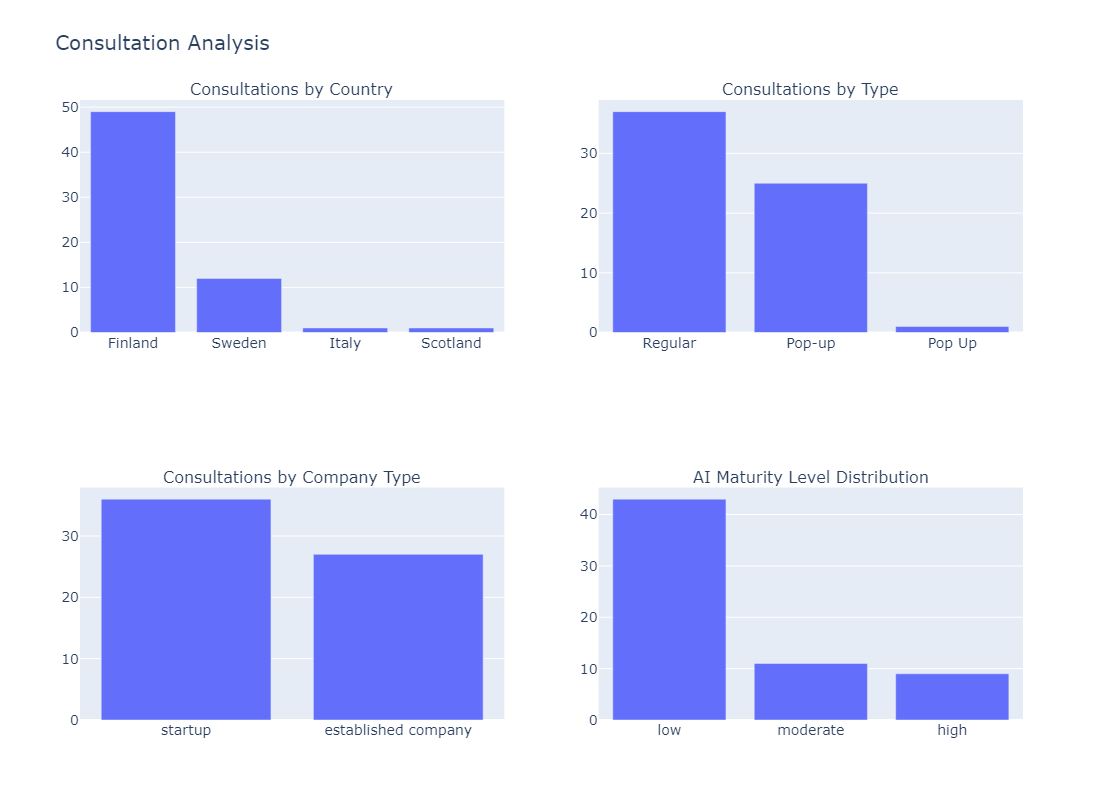

In [67]:
"""Creating graphs showing some basic statistics"""
import plotly.express as px
import plotly.subplots as sp

file_path = r"C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions/need_analysis_summary.xlsx"  

data = pd.read_excel(file_path)
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=("Consultations by Country", "Consultations by Type", 
                                                       "Consultations by Company Type", "AI Maturity Level Distribution"))

# Bar chart for 'country' sorted by descending count
country_counts = data['country'].value_counts().sort_values(ascending=False)
fig_country = px.bar(country_counts, x=country_counts.index, y=country_counts.values, 
                     labels={'x':'Country', 'y':'Count'})
for trace in fig_country.data:
    fig.add_trace(trace, row=1, col=1)

# Bar chart for 'consultation_type' sorted by descending count
consultation_type_counts = data['consultation_type'].value_counts().sort_values(ascending=False)
fig_consultation_type = px.bar(consultation_type_counts, x=consultation_type_counts.index, y=consultation_type_counts.values,
                               labels={'x':'Consultation Type', 'y':'Count'})
for trace in fig_consultation_type.data:
    fig.add_trace(trace, row=1, col=2)

# Bar chart for 'company_type' sorted by descending count
company_type_counts = data['company_type'].value_counts().sort_values(ascending=False)
fig_company_type = px.bar(company_type_counts, x=company_type_counts.index, y=company_type_counts.values,
                          labels={'x':'Company Type', 'y':'Count'})
for trace in fig_company_type.data:
    fig.add_trace(trace, row=2, col=1)

# Bar chart for 'ai_maturity_level' sorted by descending count
ai_maturity_counts = data['ai_maturity_level'].value_counts().sort_values(ascending=False)
fig_ai_maturity = px.bar(ai_maturity_counts, x=ai_maturity_counts.index, y=ai_maturity_counts.values,
                         labels={'x':'AI Maturity Level', 'y':'Count'})
for trace in fig_ai_maturity.data:
    fig.add_trace(trace, row=2, col=2)

fig.update_layout(height=800, width=1000, title_text="Consultation Analysis", 
                  font=dict(size=14), showlegend=False)

fig.show()


Loading embeddings from embeddings_recommendations.pkl...
Finding optimal number of clusters
Optimal number of clusters: 13


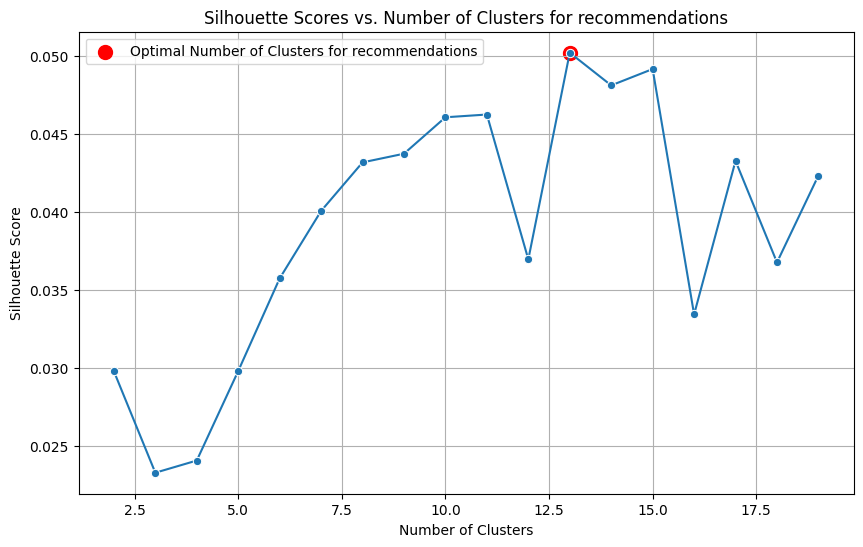


Deduplicated Clusters:

Original Clusters with Actual Number of Data Points:
Cluster 0:
  - Deeper analysis of data specifics
  - Focus on data balance
  -  consider temporal data.
  -  collect data iteratively
  -  consider data ingestion from fitness platforms.
  -  ensure all required information is supplied
  -  obtain additional work data
  -  start with simple data analyses
  - Understand data structure
  -  identify additional factors affecting wait times
  -  gather data from diverse healthcare settings
  -  Resume technical advisory services after data collection
  - Address data scarcity
  -  clarify data modeling approach for integration
  - Clarify data collection plan
  - Establish clear objectives for data use
  -  consider collecting behavioral data from patients.
  -  gather more detailed data from applicants
Cluster 6:
  -  collaboration with Aalto and Helsinki University's research groups
  -  explore existing commercial options like Werk24
  - Invite to relevant con

In [155]:
'''Finding the major topics (clusters) in a given field using k-means clustering'''

import numpy as np
import pandas as pd
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from openai import OpenAI
import pickle
import os
import seaborn as sns
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import cohere
from dotenv import load_dotenv
load_dotenv()

def fetch_embeddings(texts, filename):
    # Check if the embeddings file already exists; otherwise, create a new embedding file and save it for later use
    if os.path.exists(filename):
        print(f"Loading embeddings from {filename}...")
        with open(filename, 'rb') as f:
            embeddings = pickle.load(f)
    else: 
        print("Computing embeddings...")
        embeddings = []
        for text in texts:
            embedding = client.embeddings.create(input=[text], model="text-embedding-3-large").data[0].embedding ##for some cases text-embedding-ada-002 or text-embedding-3-small work better
            embeddings.append(embedding)
        embeddings = np.array(embeddings)
        # Save the embeddings 
        print(f"Saving embeddings to {filename}...")
        with open(filename, 'wb') as f:
            pickle.dump(embeddings, f)
    return embeddings

# # Cohre Embeddings: Get text embeddings
# COHERE_API_KEY = os.getenv("COHERE_API_KEY")
# co = cohere.Client(api_key=COHERE_API_KEY)
# def fetch_embeddings(texts, model='embed-english-v3.0', input_type="search_document"):
#     print("Computing embeddings...")
#     output = co.embed(
#         model=model,
#         input_type=input_type,
#         texts=texts)
#     return output.embeddings

# Function to plot silhouette scores
def plot_silhouette_scores(K_range, silhouette_scores, optimal_clusters, column):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=K_range, y=silhouette_scores, marker="o", dashes=False)
    optimal_index = K_range.index(optimal_clusters)
    plt.scatter(optimal_clusters, silhouette_scores[optimal_index], color='red', s=100, label=f'Optimal Number of Clusters for {column_to_analyze}')
    plt.title(f"Silhouette Scores vs. Number of Clusters for {column}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/h02317/Downloads/clusters.png')
    plt.show()

client = OpenAI(api_key=getenv('OPENAI_API_KEY'))  # Replace with your actual OpenAI API key
file_path = r"C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions/need_analysis_summary.xlsx"  # Update this to match your file path
data = pd.read_excel(file_path)
column_to_analyze = 'recommendations' ###Here we define the column we want to analyze

if column_to_analyze!= 'data_requirement_assessment' and column_to_analyze!= 'recommendations':
    data[column_to_analyze] = data[column_to_analyze].str.split(',')
    data = data.explode(column_to_analyze)
elif column_to_analyze== 'recommendations':
    data[column_to_analyze] = data[column_to_analyze].str.split(';')
    data = data.explode(column_to_analyze)
else:
    print('Bypassing comma separation...')

area_domain_data = data[column_to_analyze].dropna().tolist()

# Deduplicate the data while keeping track of the original indices
deduplicated_domains = []
original_to_dedup = []
for item in area_domain_data:
    item_lower = item.strip().lower()
    if item_lower not in deduplicated_domains:
        deduplicated_domains.append(item_lower)
    original_to_dedup.append(deduplicated_domains.index(item_lower))

filename = "embeddings_"+ column_to_analyze + ".pkl"
# Fetch embeddings for all deduplicated domain data points
embeddings = fetch_embeddings(deduplicated_domains, filename=filename)
#embeddings = fetch_embeddings(deduplicated_domains)


######Tried dimensionality reduction, but didn't get good clustering results.
################################
# # Dimensionality reduction
# print('Reducing dimensionality...')
# reducer = umap.UMAP(metric='cosine', random_state=42, low_memory=True, n_neighbors=15, n_components=15)
# embeddings_2d = reducer.fit_transform(embeddings)
# embeddings = embeddings_2d
#############################

# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
K_range = list(range(2, 20))  # Testing between 2 and the number of unique domains

print('Finding optimal number of clusters')
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42, init='k-means++')
    kmeans.fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters 
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {optimal_k}')
plot_silhouette_scores(K_range, silhouette_scores, optimal_k, column_to_analyze)
kmeans = KMeans(n_clusters=optimal_k, n_init=50, random_state=42, init='k-means++')
kmeans.fit(embeddings)
dedup_clusters = kmeans.labels_

# Map clusters back to the original data points
original_clusters = [dedup_clusters[idx] for idx in original_to_dedup]

##Get deduplicated clusters
print("\nDeduplicated Clusters:")
dedup_clustered_data = {}
for i, label in enumerate(dedup_clusters):
    if label not in dedup_clustered_data:
        dedup_clustered_data[label] = []
    dedup_clustered_data[label].append(deduplicated_domains[i])

# for cluster_id, domain_list in dedup_clustered_data.items():
#     print(f"Cluster {cluster_id}:")
#     for domain in domain_list:
#         print(f"  - {domain}")

# Get and display original clusters
print("\nOriginal Clusters with Actual Number of Data Points:")
original_clustered_data = {}
for i, label in enumerate(original_clusters):
    if label not in original_clustered_data:
        original_clustered_data[label] = []
    original_clustered_data[label].append(area_domain_data[i])

for cluster_id, domain_list in original_clustered_data.items():
    print(f"Cluster {cluster_id}:")
    for domain in domain_list:
        print(f"  - {domain}")

In [152]:
"""Removing an existing embedding file."""
import os

# Specify the file path
file_path = "embeddings_"+ "recommendations" + ".pkl"

# Remove the file
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been removed successfully.")
else:
    print(f"{file_path} does not exist.")

embeddings_recommendations.pkl has been removed successfully.


In [154]:
'''Label each cluster through gpt-4-o-mini'''
import requests
import json
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', None)

# Function to label clusters using GPT-4-o-mini
def label_clusters_with_gpt(clusters, api_key):
    cluster_descriptions = []
    for cluster_id, data_points in clusters.items():
        cluster_descriptions.append(f"Cluster {cluster_id}: {', '.join(data_points)}")
    system_message = "You are expert in annotation and assigning labels to items in a cluster"
    # input_message = (
    #     "Please label each of the following clusters with a concise, generic label"
    #     "Consider the dominant factor (data points) in each cluster for assigning labels."
    #     "Output in a JSON format where the keys are cluster numbers and the values are cluster labels."
    #     "\n\n" + "\n".join(cluster_descriptions)
    # )
    ###only for recommendation column
    input_message = (
        "Please label each of the following clusters with a concise, generic label"
        "Consider the dominant factor (data points) in each cluster for assigning labels."
        "Output in a JSON format where the keys are cluster numbers and the values are cluster labels."
        "The label should be an action or recommendation."
        "\n\n" + "\n".join(cluster_descriptions)
    )
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        "model": "gpt-4o-mini",  # Model name
        "messages": [
            {"role": "system", "content": system_message},
            {"role": "user", "content": input_message}
        ],
        "max_tokens": 2000,
        "temperature": 0.1
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    
    if response.status_code == 200:
        response_data = response.json()
        response_text = response_data['choices'][0]['message']['content'].strip()
        try:
            # Ensure that the JSON is correctly formatted
            response_text = response_text.replace("```json", "").replace("```", "").strip()
            cluster_labels = json.loads(response_text)
        except json.JSONDecodeError as e:
            print("Failed to parse JSON:", e)
            cluster_labels = {}
        
        return cluster_labels
    else:
        print(f"Request failed with status code {response.status_code}")
        print("Response Body:", response.text)
        return None

# Function to convert the JSON labeled clusters into a DataFrame
def clusters_to_dataframe(cluster_labels, clusters, original_clustered_data):
    data = {"Cluster Number": [], "Label": [], "Unique Data Points": [], "Original Data Points": []}
    
    # Iterate through the cluster labels
    for cluster_num, label in cluster_labels.items():
        cluster_num = int(cluster_num)  # Convert cluster number to integer
        data["Cluster Number"].append(cluster_num)
        data["Label"].append(label)
        data["Unique Data Points"].append(repr(clusters[cluster_num]))  # Use repr to retain the original list format
        data["Original Data Points"].append(len(original_clustered_data[cluster_num]))  # Count original data points
    
    # Convert to DataFrame and sort by "Cluster Number"
    df = pd.DataFrame(data)
    df = df.sort_values(by='Cluster Number').reset_index(drop=True)
    return df

api_key = os.getenv('OPENAI_API_KEY')

# Use dedup_clustered_data and original_clustered_data from previous code
labeled_clusters = label_clusters_with_gpt(dedup_clustered_data, api_key)
df_labeled_clusters = clusters_to_dataframe(labeled_clusters, dedup_clustered_data, original_clustered_data)
df_labeled_clusters

,Cluster Number,Label,Unique Data Points,Original Data Points
0,0,Conduct Comprehensive Data Analysis,"['deeper analysis of data specifics', 'focus on data balance', 'consider temporal data.', 'collect data iteratively', 'consider data ingestion from fitness platforms.', 'ensure all required information is supplied', 'obtain additional work data', 'start with simple data analyses', 'understand data structure', 'identify additional factors affecting wait times', 'gather data from diverse healthcare settings', 'resume technical advisory services after data collection', 'address data scarcity', 'clarify data modeling approach for integration', 'clarify data collection plan', 'establish clear objectives for data use', 'consider collecting behavioral data from patients.', 'gather more detailed data from applicants']",18
1,1,Implement Rule-Based Systems,"['start with simple rule-based system', 'start with rule-based systems', 'focus on speaker identification', 'prioritize use case specification', 'explore rule-based systems for disease prediction.', 'implement semantic matching for symptom identification', 'start with facial recognition', 'experiment with a rule-based system', 'begin with a simple matchmaking system', 'focus on rule-based system', 'consider rule-based automation.']",11
2,2,Develop Incremental AI Integration Strategy,"['adopt incremental ai integration', 'use incremental approach for ai integration', 'build ai model for skill mapping', 'employ explainable ai methods.', 'conduct investigation on ai impact', 'refine ai methodologies', 'ensure alignment of ai strategy with business objectives', 'focus on ai strategy development', 'use ai-driven search engines for expert identification', 'explore openai’s assistant api', 'develop a well-defined ai solution roadmap', 'incorporate ai functionalities', 'transition to ai-based system gradually', 'prioritize tasks for ai integration', 'investigate ai/ml integration', 'apply ai for categorizing cards', 'develop a clear ai technology roadmap', 'evaluate ai quality', 'explore traditional methods before ai', 'clarify if ai integration is necessary', 'consider explainable ai', 'invest in ai/machine learning expertise']",22
3,3,Experiment with Machine Learning Models,"['explore zero-shot learning', 'explore fundamental machine learning algorithms', 'implement decision tree or ensemble learning algorithms', 'use lstm for forecasting', 'fit different models with various predictor variables', 'explore gradient boosting', 'consider missing value imputation methods', 'experiment with vector databases', 'explore music-specialized ai models', 'define final model outcome', 'perform time-series analysis for patient monitoring', 'ensure balanced dataset', 'expand dataset using data augmentation', 'test and compare different ai models', 'utilize open-source sentiment analysis models', 'utilize pre-trained models for segmentation', 'try yolov9', 'focus on training data quality and quantity', 'explore ensemble models', 'explore open-source models.', 'explore open-source language models', 'explore simulation of manufacturing processes.', 'consider synthetic data generation', 'improve detection models with larger datasets', 'explore u-net for segmentation', 'experiment with basic machine learning algorithms', 'use logistic regression for initial predictions', 'experiment with open-source ai models', 'build a predictive model leveraging all data sources', 'look for open-source predictive models and open data for cardiac signal analysis', 'utilize historical data for statistical modeling', 'focus on specific diseases for prediction', 'start with basic machine-learning algorithms', 'explore advanced models for complex data.']",34
4,4,Ensure Ethical Data Practices,"['prioritize transparency', 'ensure ethical practices', 'ensure model reliability and transparency', 'address data privacy issues', 'ensure ethical content compliance', 'ensure data privacy', 'ensure compliance with regulations', 'conduct 

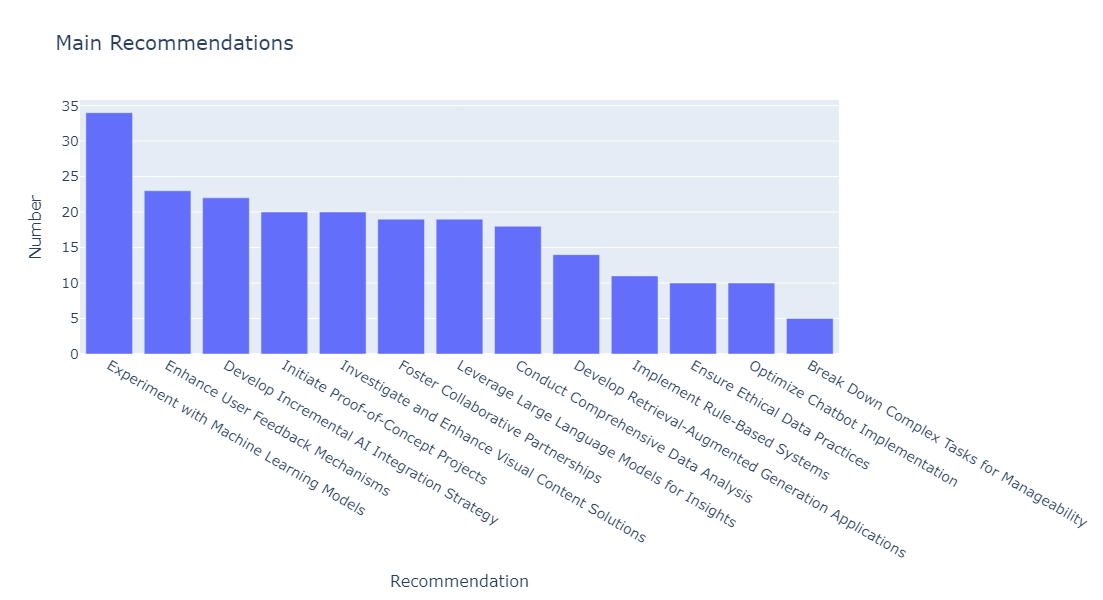

In [120]:
import plotly.express as px

# Use the "Original Data Points" column for the number of companies
df_labeled_clusters['No. of companies'] = df_labeled_clusters['Original Data Points']

# Filter out rows where 'No. of companies' is less than or equal to 1
filtered_data = df_labeled_clusters[df_labeled_clusters['No. of companies'] > 3]

fig = px.bar(filtered_data, 
             x='Label', 
             y='No. of companies', 
             title="Main Recommendations", 
             labels={'Label': 'Topics', 'No. of companies': 'No. of Topics'})

fig.update_layout(
    xaxis_title="Recommendation",
    yaxis_title="Number",
    xaxis=dict(
        categoryorder='total descending',  
        tickfont=dict(size=14)  
    ),
    yaxis=dict(
        type='linear',
        tickfont=dict(size=14)  
    ),
    showlegend=False,
    height=600,  
    title_font_size=20,  
    xaxis_title_font_size=16,  
    yaxis_title_font_size=16  
)

# Display the figure
fig.show()


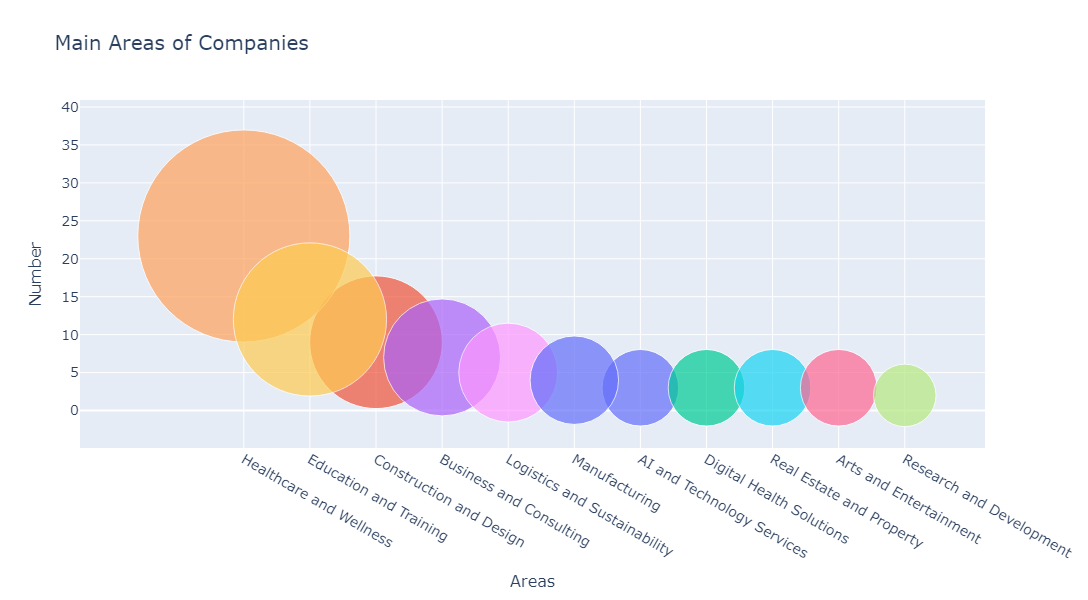

In [82]:
import plotly.express as px

# Use the "Original Data Points" column for the number of companies
df_labeled_clusters['No. of companies'] = df_labeled_clusters['Original Data Points']

# Filter out rows where 'No. of companies' is less than or equal to 1
filtered_data = df_labeled_clusters[df_labeled_clusters['No. of companies'] > 1]

fig = px.scatter(filtered_data, 
                 x='Label', 
                 y='No. of companies', 
                 size='No. of companies',  
                 title="Main Areas of Companies", 
                 labels={'Label': 'Topics', 'No. of companies': 'No. of Topics'},
                 size_max=150,  
                 color='Label') 

fig.update_layout(
    xaxis_title="Areas",
    yaxis_title="Number",
    xaxis=dict(
        categoryorder='total descending',  
        tickfont=dict(size=14)  
    ),
    yaxis=dict(
        type='linear',
        tickfont=dict(size=14) 
    ),
    showlegend=False,
    height=600, 
    title_font_size=20,  
    xaxis_title_font_size=16,  
    yaxis_title_font_size=16 
)

fig.show()


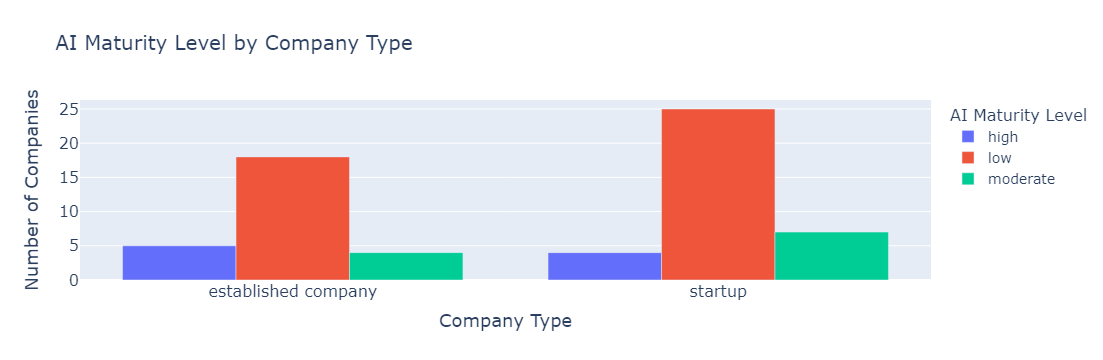

In [68]:
# Perform segmentation analysis by 'ai_maturity_level' and 'company_type'
segmentation_data = data.groupby(['company_type', 'ai_maturity_level']).size().reset_index(name='counts')

fig = px.bar(segmentation_data, 
             x='company_type', 
             y='counts', 
             color='ai_maturity_level', 
             barmode='group',
             labels={'company_type': 'Company Type', 'counts': 'Number of Companies', 'ai_maturity_level': 'AI Maturity Level'},
             title='AI Maturity Level by Company Type')

fig.update_layout(
    title_font_size=20, 
    xaxis_title_font_size=18,  
    yaxis_title_font_size=18,  
    legend_title_font_size=16,  
    legend_font_size=14,  
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16))  
)

fig.show()

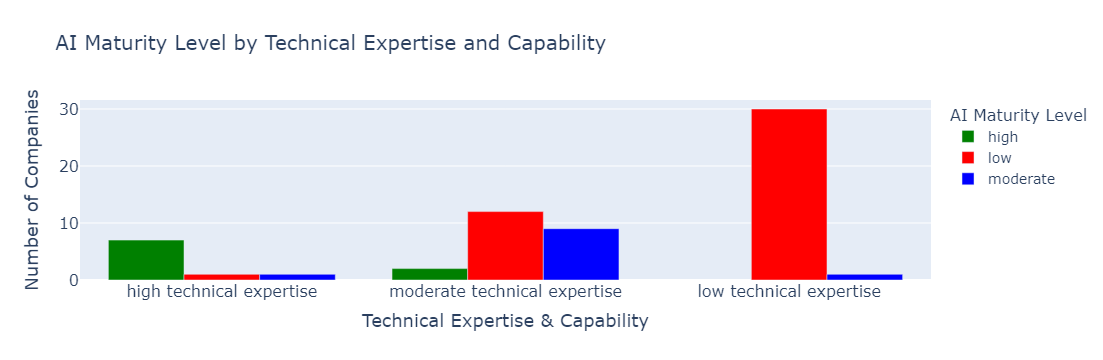

In [69]:
import pandas as pd
import plotly.express as px

file_path = r"C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions/need_analysis_summary.xlsx"
data = pd.read_excel(file_path)

color_mapping = {'high': 'green', 'low': 'red', 'moderate': 'blue'}

if 'technical_expertise_and_capability' in data.columns:
    segmentation_data = data.groupby(['technical_expertise_and_capability', 'ai_maturity_level']).size().reset_index(name='counts')

    segmentation_data['technical_expertise_and_capability'] = segmentation_data['technical_expertise_and_capability'].replace({
        'moderate': 'moderate technical expertise', 
        'high': 'high technical expertise', 
        'low': 'low technical expertise'
    })

    fig = px.bar(segmentation_data, 
                 x='technical_expertise_and_capability', 
                 y='counts', 
                 color='ai_maturity_level', 
                 color_discrete_map=color_mapping,  
                 barmode='group',
                 labels={'technical_expertise_and_capability': 'Technical Expertise & Capability', 
                         'counts': 'Number of Companies', 'ai_maturity_level': 'AI Maturity Level'},
                 title='AI Maturity Level by Technical Expertise and Capability')

    fig.update_layout(
        title_font_size=20,
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        legend_title_font_size=16,
        legend_font_size=14,
        xaxis=dict(tickfont=dict(size=16)), 
        yaxis=dict(tickfont=dict(size=16))  
    )

    fig.show()
else:
    print("The column 'technical_expertise_and_capability' does not exist in the dataset.")

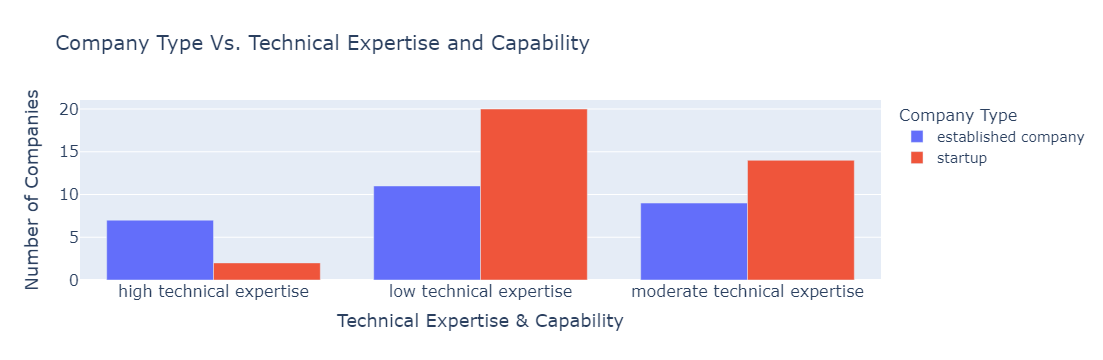

In [70]:
import pandas as pd
import plotly.express as px

file_path = r"C:/Users/h02317/OneDrive - Haaga-Helia Oy Ab/Advisory sessions/Feedbacks/Need analysis sessions/need_analysis_summary.xlsx"
data = pd.read_excel(file_path)

color_mapping = {'high': 'green', 'low': 'red', 'moderate': 'blue'}

if 'technical_expertise_and_capability' in data.columns:
    segmentation_data = data.groupby(['technical_expertise_and_capability', 'company_type']).size().reset_index(name='counts')

    segmentation_data['technical_expertise_and_capability'] = segmentation_data['technical_expertise_and_capability'].replace({
        'moderate': 'moderate technical expertise', 
        'high': 'high technical expertise', 
        'low': 'low technical expertise'
    })

    fig = px.bar(segmentation_data, 
                 x='technical_expertise_and_capability', 
                 y='counts', 
                 color='company_type', 
                 barmode='group',
                 labels={'technical_expertise_and_capability': 'Technical Expertise & Capability', 
                         'counts': 'Number of Companies', 'company_type': 'Company Type'},
                 title='Company Type Vs. Technical Expertise and Capability')

    fig.update_layout(
        title_font_size=20,
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        legend_title_font_size=16,
        legend_font_size=14,
        xaxis=dict(tickfont=dict(size=16)), 
        yaxis=dict(tickfont=dict(size=16))   
    )

    fig.show()
else:
    print("The column 'technical_expertise_and_capability' does not exist in the dataset.")
